# TP THP by **Melzi Mounir** and **Guedda Fatima Zahraa** - 1CS G7

> **Dans ce TP on va transformer un automate d'états finis généralisé vers un automate d'états finis simple en passant par un automate d'états finis partiellement généralisé**
 
> ## Les types des automates d'états finis:
>> ### Généralisé:
>> Un automate d'états finis généralisé est un 5-uplets **$A_{G}$ < $X^{*}$ , $S_{G}$ , $S_{0G}$ , $F_{G}$ , $I_{G}$ >** où:
>> - **$X$** est l’alphabet d’entrée
>> - **$S_{G}$** est un ensemble fini d’états de l’automate
>> - **$S_{0G}$** est l’état initial $S_{0G} \in S_{G}$
>> - **$F_{G}$** est l’ensemble des états finaux $F_{G} \subseteq S_{G}$
>> - **$I_{G}$** est l’ensemble des instructions $I_{G} : S_{G}$ x $X^{*}$ &rarr; $P(S_{G})$
>
>> ### Partiellement Généralisé:
>> Un automate d'états finis partiellement généralisé est un 5-uplets **$A_{PG}$ < $X \cup \{\epsilon\}$ , $S_{PG}$ , $S_{0PG}$ , $F_{PG}$ , $I_{PG}$ >** où:
>> - **$X$** est l’alphabet d’entrée
>> - **$S_{PG}$** est un ensemble fini d’états de l’automate
>> - **$S_{0PG}$** est l’état initial $S_{0PG} \in S_{PG}$
>> - **$F_{PG}$** est l’ensemble des états finaux $F_{PG} \subseteq S_{PG}$
>> - **$I_{PG}$** est l’ensemble des instructions $I_{PG} : S_{PG}$ x $X \cup \{\epsilon\}$ &rarr; $P(S_{PG})$
> 
>> ### Simple:
>> Un automate d'états finis simple est un 5-uplets **$A$ < $X$ , $S$ , $S_{0}$ , $F$ , $I$ >** où:
>> - **$X$** est l’alphabet d’entrée
>> - **$S$** est un ensemble fini d’états de l’automate
>> - **$S_{0}$** est l’état initial $S_{0} \in S$
>> - **$F$** est l’ensemble des états finaux $F \subseteq S$
>> - **$I$** est l’ensemble des instructions $I : S$ x $X$ &rarr; $S$

> ## Les étapes de la solution:
> 1. Définition de la structure d'un automate d'états finis en `python`.
> 2. Transformation de l'automate généralisé vers un automate partiellement généralisé en éliminant les transitions qui se font par un mot dont la longueur est supérieure ou égale à 2, par l'ajout des états intermédiaires.
> 3. Transformation de l'automate partiellement généralisé vers un automate simple en éliminant les transitions epsilon. Si on a ($S_{i}$, $\epsilon$, $S_{j}$), on applique ces 2 règles:
>     1. On va créer des transitions entre $S_{i}$ et tous les successeurs directes de $S_{j}$
>     2. Si $S_{j}$ est un état final dans $A$ alors $S_{i}$ devient un état final dans le nouvel automate construit

In [31]:
# import python modules
import graphviz
import pprint
import shutil
from matplotlib import pyplot as plt
from matplotlib import image as mimg

In [32]:
class Automate:
    def __init__(
        self,
        X: set[str],  # alphabet
        S: set[str],  # states
        S0: str,  # initial state
        F: set[str],  # final states
        I: dict[str, dict[str, set[str]]],  # instructions
    ) -> None:
        assert all(map(lambda x: len(x) == 1, X))
        assert S0 in S
        assert F.issubset(S)
        for state in I:
            assert state in S
            for word in I[state]:
                assert all(map(lambda char: char in X, word))
                states = I[state][word]
                assert states.issubset(S)

        self.X = X
        self.S = S
        self.S0 = S0
        self.F = F
        self.I = I

    def eliminate_long_words(self) -> None:
        """
        Transformer l'automate généralisé vers un automate partiellement généralisé
        """
        
        temp_automate = Automate(
            X=self.X.copy(),
            S=self.S.copy(),
            S0=str(self.S0),
            F=self.F.copy(),
            I=dict(),
        )

        counter = 0
        prefix = "I"

        for Si in self.I:
            for word in self.I[Si]:
                for Sj in self.I[Si][word]:
                    if len(word) <= 1:
                        temp_automate.add_instruction(Si, word, Sj)
                    else:
                        counter += 1
                        temp_automate.S.add(prefix + str(counter))
                        temp_automate.add_instruction(Si, word[0], prefix + str(counter))
                        for char in word[1:-1]:
                            counter += 1
                            temp_automate.S.add(prefix + str(counter))
                            temp_automate.add_instruction(prefix + str(counter - 1), char, prefix + str(counter))
                        temp_automate.add_instruction(prefix + str(counter), word[-1], Sj)

        self.X = temp_automate.X
        self.S = temp_automate.S
        self.S0 = temp_automate.S0
        self.F = temp_automate.F
        self.I = temp_automate.I

    def eliminate_empty_words(self) -> None:
        """
        Transformer l'automate partiellement généralisé vers un automate simple
        """

        transitions_to_delete = set()
        transitions_to_add = set()
        _transitions_to_add = set()

        for Si in self.I:
            for w in self.I[Si]:
                if w: continue

                for Sj in self.I[Si][w]:
                    transitions_to_delete.add((Si, w, Sj))
                    if Sj in self.F:
                        self.F.add(Si)

                    for word in self.I.get(Sj, dict()).keys():
                        for state in self.I.get(Sj, dict())[word]:
                            if word or ((state != Si) and ((Sj, word, state) not in transitions_to_delete)):
                                transitions_to_add.add((Si, word, state))

                        for state in map(lambda x: x[2], filter(lambda x: ((x[0] == Sj) and (x[1] == word)), transitions_to_add)):
                            if word or ((state != Si) and ((Sj, word, state) not in transitions_to_delete)):
                                _transitions_to_add.add((Si, word, state))
                            
        for transition in transitions_to_delete:
            Si, w, Sj = transition
            self.delete_instruction(Si, w, Sj)

        for transition in transitions_to_add.union(_transitions_to_add):
            Si, word, Sj = transition
            self.add_instruction(Si, word, Sj)

    def add_instruction(self, Si: str, w: str, Sj: str) -> None:
        assert Si in self.S
        assert Sj in self.S
        assert all(map(lambda char: char in self.X, w))
        
        if self.I.get(Si, None):
            if self.I[Si].get(w, None):
                self.I[Si][w].add(Sj)
            else:
                self.I[Si][w] = {Sj}
        else:
            self.I[Si] = {w: {Sj}}

    def delete_instruction(self, Si: str, w: str, Sj: str) -> None:
        assert Si in self.S
        assert Sj in self.S
        assert all(map(lambda char: char in self.X, w))

        if self.I.get(Si, None):
            if self.I[Si].get(w, None):
                self.I[Si][w].remove(Sj)
                if not self.I[Si][w]:
                    del self.I[Si][w]
                    if not self.I[Si]:
                        del self.I[Si]

    def is_simple(self) -> bool:
        """
        Vérifier si l'automate est simple

        Returns:
            bool: True si l'automate est simple, False sinon
        """

        for state in self.I:
            for word in self.I[state]:
                if len(word) != 1:
                    return False
        return True
    
    def print(self) -> None:
        """
        Afficher l'automate en format textuel
        """

        print("\n[X] Alphabet:")
        pprint.pprint(self.X)
        print("\n[S] States:")
        pprint.pprint(self.S)
        print("\n[S0] Initial State:")
        pprint.pprint(self.S0)
        print("\n[F] Final States:")
        pprint.pprint(self.F)
        print("\n[I] Instructions:")
        pprint.pprint(self.I)
        print()

    def render(self, directory: str = "temp", filename: str = "temp") -> None:
        """
        Afficher l'automate en format graphique dans une image .png

        Args:
            directory (str, optional): Le répertoire du sauvegarde. Defaults to "temp".
            filename (str, optional): Le nom de l'image. Defaults to "temp".
        """

        g = graphviz.Digraph(format="png", directory=directory, filename=filename)
        g.attr(rankdir="LR")

        # draw the states
        g.attr(
            "node",
            shape="doublecircle" if self.S0 in self.F else "circle",
            color="green",
        )
        g.node(self.S0)

        g.attr("node", shape="circle", color="black")
        for state in self.S:
            if state in self.F or state == self.S0:
                continue
            g.node(state)

        g.attr("node", shape="doublecircle", color="black")
        for state in self.F:
            g.node(state)

        # draw the transitions
        g.attr("node", shape="point")
        g.edge("", self.S0)

        g.attr("node", shape="circle", color="black")
        for Si in self.I:
            for word in self.I[Si]:
                for Sj in self.I[Si][word]:
                    g.edge(Si, Sj, label=word)
        
        g.render(cleanup=True)

In [33]:
def render(automate: Automate) -> None:
    """
    Visualizer un automate graphiquement

    Args:
        automate (Automate): L'automate à visualizer graphiquement
    """
    
    automate.render()
    fig = plt.imshow(mimg.imread("temp/temp.png"))
    fig.set_cmap('hot')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    shutil.rmtree("temp")

## Créer une instance d'un Automate généralisé


[X] Alphabet:
{'b', 'a'}

[S] States:
{'S0', 'S2', 'S1'}

[S0] Initial State:
'S0'

[F] Final States:
{'S2'}

[I] Instructions:
{'S0': {'': {'S2'}, 'a': {'S1'}, 'ba': {'S0'}},
 'S1': {'b': {'S2', 'S1'}, 'bab': {'S2'}},
 'S2': {'': {'S1'}, 'a': {'S2'}}}



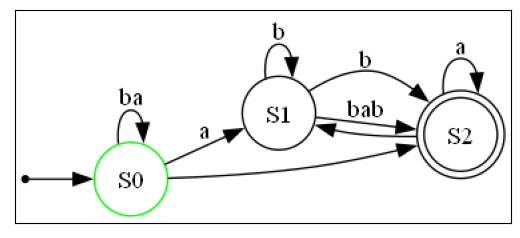

In [34]:
automate = Automate(
    X={"a", "b"},
    S={"S0", "S1", "S2"},
    S0="S0",
    F={"S2"},
    I={
        "S0": {
            "a": {"S1"},
            "ba": {"S0"},
            "": {"S2"},
        },
        "S1": {
            "b": {"S1", "S2"},
            "bab": {"S2"},
        },
        "S2": {
            "a": {"S2"},
            "": {"S1"},
        },
    },
)

automate.print()
render(automate)

## Passer à l'automate partiellement généralisé


[X] Alphabet:
{'b', 'a'}

[S] States:
{'I2', 'I3', 'S0', 'S2', 'I1', 'S1'}

[S0] Initial State:
'S0'

[F] Final States:
{'S2'}

[I] Instructions:
{'I1': {'a': {'S0'}},
 'I2': {'a': {'I3'}},
 'I3': {'b': {'S2'}},
 'S0': {'': {'S2'}, 'a': {'S1'}, 'b': {'I1'}},
 'S1': {'b': {'S2', 'I2', 'S1'}},
 'S2': {'': {'S1'}, 'a': {'S2'}}}



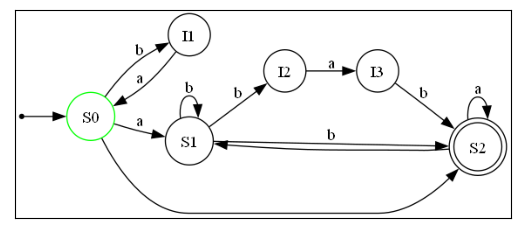

In [35]:
automate.eliminate_long_words()

automate.print()
render(automate)

## Passer à l'automate simple


[X] Alphabet:
{'b', 'a'}

[S] States:
{'I2', 'I3', 'S0', 'S2', 'I1', 'S1'}

[S0] Initial State:
'S0'

[F] Final States:
{'S2', 'S0'}

[I] Instructions:
{'I1': {'a': {'S0'}},
 'I2': {'a': {'I3'}},
 'I3': {'b': {'S2'}},
 'S0': {'a': {'S2', 'S1'}, 'b': {'S2', 'I1', 'I2', 'S1'}},
 'S1': {'b': {'S2', 'I2', 'S1'}},
 'S2': {'a': {'S2'}, 'b': {'S2', 'I2', 'S1'}}}



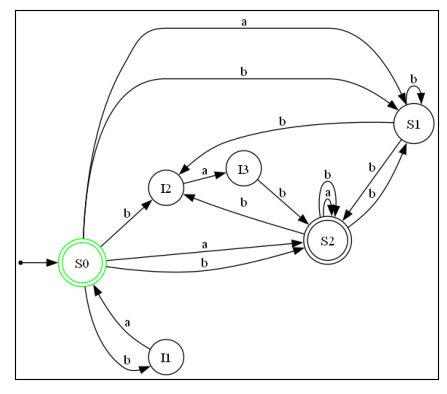

In [36]:
while not automate.is_simple():
    automate.eliminate_empty_words()

automate.print()
render(automate)